# Argentina - Pampa Energia SA (PAMP)

Stock price prediction of Argentina - Pampa Energia SA (PAMP) for the first quater year using the data from past year.

Given the trading data of Pampa Energia SA (PAMP) from 2020 Q1 to 2021 Q1 stock prices. This notebook aims to train different ML models on data from 2020 and predict stock prices for the 2021 Q1 data. Finally, recommendations are provided (BUY, HOLD, and SELL decisions) to maximize capital returns and minimize losses.

Import the necessary libraries to use numpy array, pandas dataframe and matlpotlib for visualtion. Further, different models are implemented using keras, prophet, and statsmodels libraries and data preprocessing from scikit-learn. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Content of this notebook

1. Read Data
2. Data Exploration
3. Benchmark Model
   - 3.1 ARIMA
   - 3.2 Rolling ARIMA
4. Data Preprocessing
5. Model Training
   - 5.1 Long Short-Term Memory
   - 5.2 Prophet
6. Optimal Strategy
7. Model Artifacts
8. Bollinger Bands

## 1. Read Data

The data related to stock prices of Pampa Energia SA (PAMP) is downloaded from '2020Q1Q2Q3Q4-2021Q1.xlsx' excel file.

The last row of the sheet contains the following statistics about the 'Price' column, i.e. highest price, lowest price, difference between highest and lowest price, average price, and percentage change in price. `skipfooter` attribute of read_csv is used to remove that line from dataframe.

In [2]:
df = pd.read_excel('2020Q1Q2Q3Q4-2021Q1.xlsx', sheet_name='Argentina - Pampa Energia SA (P', skipfooter=1).iloc[::-1]

In [3]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
299,2020-01-02,48.25,49.35,50.20,47.55,878.50K,-0.0292
298,2020-01-03,48.80,48.25,49.45,46.50,595.36K,0.0114
297,2020-01-06,48.50,48.40,48.70,47.00,719.24K,-0.0061
296,2020-01-07,47.60,48.35,49.00,46.90,901.95K,-0.0186
295,2020-01-08,46.50,47.50,47.50,46.00,1.18M,-0.0231


The 'Vol.' column is string variable with 'M' as suffix. Let's remove the 'M' and convert it to float.

In [4]:
df['Vol.'] = df['Vol.'].apply(lambda x: float(x[:-1]))

Set target variable and the input features.

In [5]:
output = pd.DataFrame(df['Price'])
input_cols = ['Open', 'High', 'Low', 'Vol.', 'Change %']

The information about stock prices from the Excel sheet is read using the `pd.read_excel` function and stored as a `DataFrame`. This dataset includes the following columns 
- Date: Date in the following format 'YYYY-MM-DD'.
- Price: Stock price at the end of the day.
- Open: Stock price at the start of the day.
- High: The highest price of the stock for the day.
- Low: The lowest price of the stock for the day.
- Vol.: The volume of stock purchased on the day.
- Change %: Percent change in the stock price over the day.

The next step is to perform an exploratory data analysis to identify any missing values or clean the data set for model training.

## 2. Data Exploration

This section presents an exploratory data analysis (EDA) for the stock price dataset. This includes the search for missing values, description of numerical attributes, and visualization of variation in stock prices over the last five quaters. 

Check for the missing values in the dataset.

In [6]:
print("Number of missing values: ", df.isnull().values.sum())

Number of missing values:  0


The initial dataset shows that the 'Price', 'Open', 'High', and 'Low' has similar distribution, this behavior is expected as they indicate the stock price for the same day but different time. The range of 'Vol.' and 'Change %' is different from other attributes thus scaling all attributes before training will be useful for model prediction.

In [7]:
df.describe()

,Date,Price,Open,High,Low,Vol.,Change %
count,300,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,2020-08-15 12:38:24,61.244000,61.129333,62.736000,59.523833,386.083767,0.002445
min,2020-01-02 00:00:00,33.000000,32.000000,36.150000,32.000000,1.010000,-0.134000
25%,2020-04-26 06:00:00,46.850000,47.000000,48.000000,45.537500,1.995000,-0.018525
50%,2020-08-16 00:00:00,57.750000,57.825000,58.925000,56.075000,391.700000,0.001850
75%,2020-12-03 06:00:00,78.500000,78.350000,80.925000,76.387500,650.490000,0.020750
max,2021-03-31 00:00:00,88.900000,89.000000,90.000000,86.800000,986.340000,0.183800
std,NaN,16.163933,16.042200,16.347964,15.919459,325.853038,0.036209


Pandas offers a built-in capability to plot autocorrelations. The following plot shows the autocorrelation for an extensive set of time series lags:

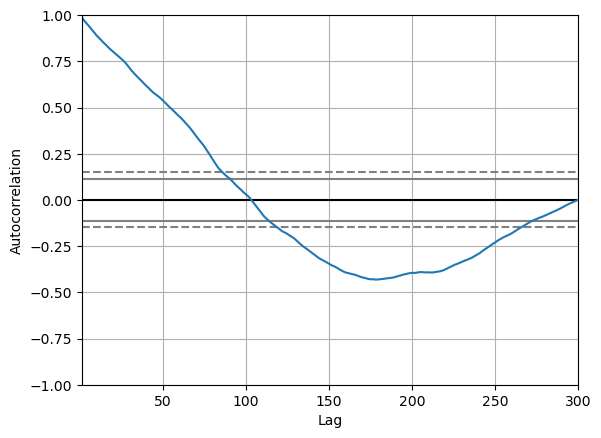

In [8]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df.Price)
plt.show()

Notice that there is a positive correlation with the first 50 lags that is perhaps significant for the first 10 lags.

This provides a hint: initiating the AR parameter for the ARIMA model with a value of 50 could be a beneficial starting point.

The plot below illustrates the stock price for 2020 (blue color) and 2021 Q1 (orange color).

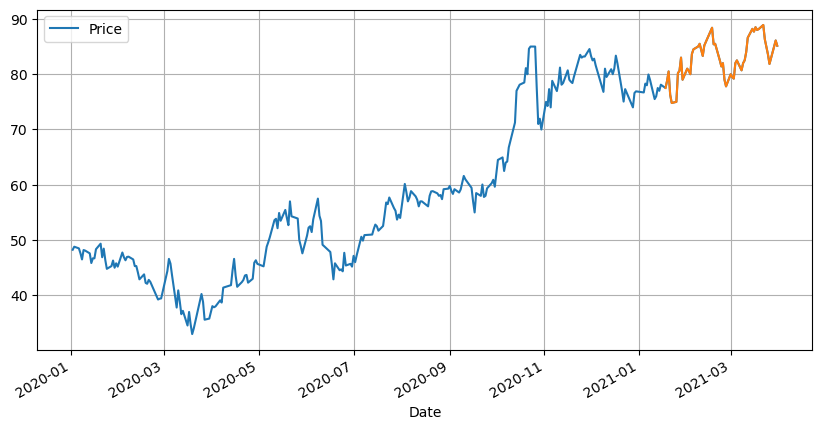

In [9]:
len_train = 250  # number of data points in this year 2020
df.plot(x='Date', y='Price', figsize=(10, 5))
plt.plot(df.iloc[len_train:]['Date'], df.iloc[len_train:]['Price'], label='Test Data')
plt.grid()
plt.show()

This suggests that the time series is not stationary and will require differencing to make it stationary, at least a difference order of 1.

In [10]:
arima_data = df.copy()
arima_data.head()

,Date,Price,Open,High,Low,Vol.,Change %
299,2020-01-02,48.25,49.35,50.20,47.55,878.50,-0.0292
298,2020-01-03,48.80,48.25,49.45,46.50,595.36,0.0114
297,2020-01-06,48.50,48.40,48.70,47.00,719.24,-0.0061
296,2020-01-07,47.60,48.35,49.00,46.90,901.95,-0.0186
295,2020-01-08,46.50,47.50,47.50,46.00,1.18,-0.0231


In [11]:
from statsmodels.tsa.stattools import adfuller

In [12]:
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

adf_test(arima_data['Price'])

ADF Statistic: -0.7413478173434277
p-value: 0.8357469289607864
Critical Values: {'1%': -3.4524113009049935, '5%': -2.8712554127251764, '10%': -2.571946570731871}


Differencing to make the time series stationary

In [13]:
arima_data['Differenced_Price'] = arima_data['Price'] - arima_data['Price'].shift(1)
arima_data = arima_data.dropna()
adf_test(arima_data['Differenced_Price'])

ADF Statistic: -18.349666199328862
p-value: 2.2378052806172923e-30
Critical Values: {'1%': -3.4524859843440754, '5%': -2.871288184343229, '10%': -2.571964047565425}


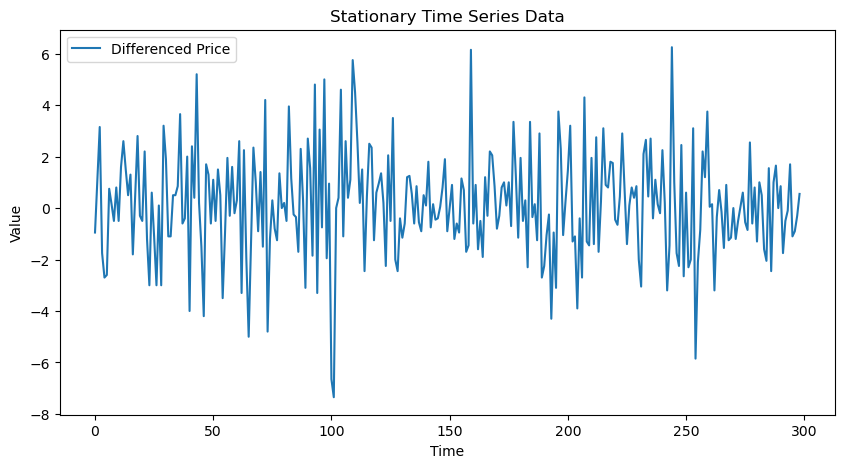

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(arima_data.index, arima_data['Differenced_Price'], label='Differenced Price')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Stationary Time Series Data')
plt.legend()
plt.show()

ACF and PACF plots for determining ARIMA orders

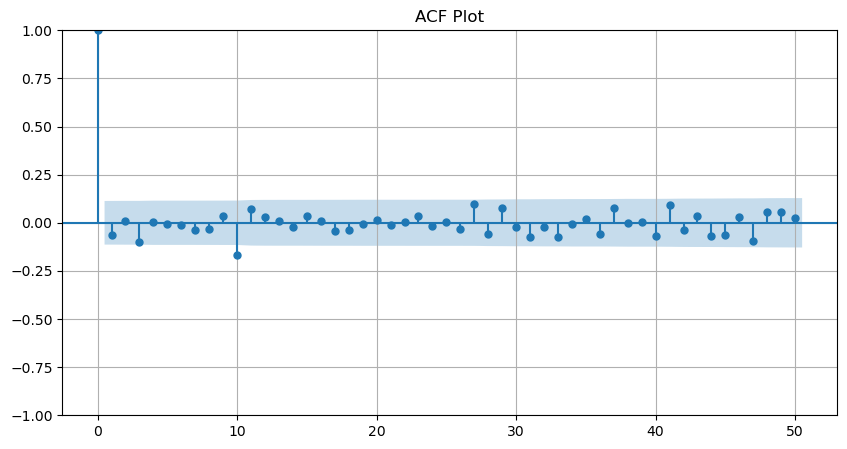

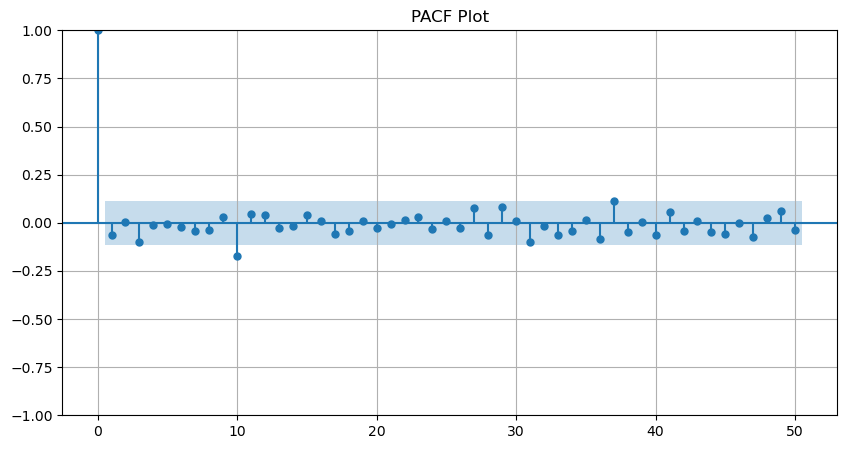

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10, 5))
plot_acf(arima_data['Differenced_Price'], lags=50, ax=plt.gca())
plt.title('ACF Plot')
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plot_pacf(arima_data['Differenced_Price'], lags=50, ax=plt.gca())
plt.title('PACF Plot')
plt.grid()
plt.show()

### 3 Benchmark Model

#### 3.1 AutoRegrssive Integrated Model Average (ARIMA)

- Autoregression (AR): A model that uses the correlation between the current observation and lagged observations. The number of lagged observations is referred to as the lag order or p.
- Integrated (I): The use of differencing of raw observations to make the time series stationary. The number of differencing operations is referred to as d.
- Moving Average (MA): A model takes into account the relationship between the current observation and the residual errors from a moving average model applied to past observations. The size of the moving average window is the order or q.

The ARIMA model is defined with the notation ARIMA(p,d,q) where p, d, and q are substituted with integer values to specify the exact model being used.

In [16]:
from statsmodels.tsa.arima.model import ARIMA

In [17]:
arima_model = ARIMA(arima_data['Differenced_Price'].iloc[:len_train], order=(0, 1, 0))
arima_model_fit = arima_model.fit()

/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [18]:
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:      Differenced_Price   No. Observations:                  250
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -627.500
Date:                Wed, 03 Jan 2024   AIC                           1257.000
Time:                        18:16:36   BIC                           1260.518
Sample:                             0   HQIC                          1258.416
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         9.0456      0.750     12.063      0.000       7.576      10.515
Ljung-Box (L1) (Q):                  75.52   Jarque-Bera (JB):                 1.31
Prob(Q):                              0.00   Pr

In [19]:
list(arima_model_fit.predict()[1:])

[0.5499999999999973,
 -0.29999999999999716,
 -0.9000000000100224,
 -1.1000000000000014,
 1.700000000000003,
 -0.1000000000000012,
 -0.5,
 -1.75,
 0.8500000000000016,
 0.0,
 1.6499999999999986,
 0.9999999999999999,
 -2.450000000000003,
 1.5500000000000043,
 -2.050000000000004,
 -1.6000000000000014,
 0.5,
 1.0,
 -1.299999999999997,
 0.7999999999999974,
 -0.5999999999999942,
 2.549999999999997,
 -0.8500000000000014,
 -0.5499999999999972,
 0.6000000000000013,
 0.04999999999999716,
 -0.4999999999999999,
 -1.2000000000000028,
 0.0,
 -1.1499999999999984,
 -1.25,
 0.8999999999999986,
 -1.549999999999997,
 -0.14999999999999836,
 0.6999999999999957,
 -0.3499999999999943,
 -3.2000000000000033,
 0.14999999999999813,
 0.05000000000000426,
 3.75,
 1.1999999999999962,
 2.200000000000003,
 -0.8500000000000014,
 -2.1000000000000014,
 -5.850000000000001,
 3.1000000000000005,
 -1.9999999999999996,
 -2.299999999999997,
 0.6000000000000014,
 -2.6500000000000057,
 2.4500000000000024,
 -2.25,
 -1.75,
 0.9999

In [20]:
arima_data.loc[:len(arima_data)-len_train+1]

,Date,Price,Open,High,Low,Vol.,Change %,Differenced_Price
298,2020-01-03,48.8,48.25,49.45,46.50,595.36,0.0114,0.55
297,2020-01-06,48.5,48.40,48.70,47.00,719.24,-0.0061,-0.30
296,2020-01-07,47.6,48.35,49.00,46.90,901.95,-0.0186,-0.90
295,2020-01-08,46.5,47.50,47.50,46.00,1.18,-0.0231,-1.10
294,2020-01-09,48.2,46.55,48.50,46.05,1.77,0.0366,1.70
...,...,...,...,...,...,...,...,...
54,2021-01-11,75.5,76.70,77.20,73.80,251.45,-0.0443,-3.50
53,2021-01-12,76.0,74.55,78.00,73.20,436.60,0.0066,0.50
52,2021-01-13,77.5,76.05,78.00,75.50,253.17,0.0197,1.50
51,2021-01-14,77.0,78.00,78.50,75.80,741.08,-0.0065,-0.50


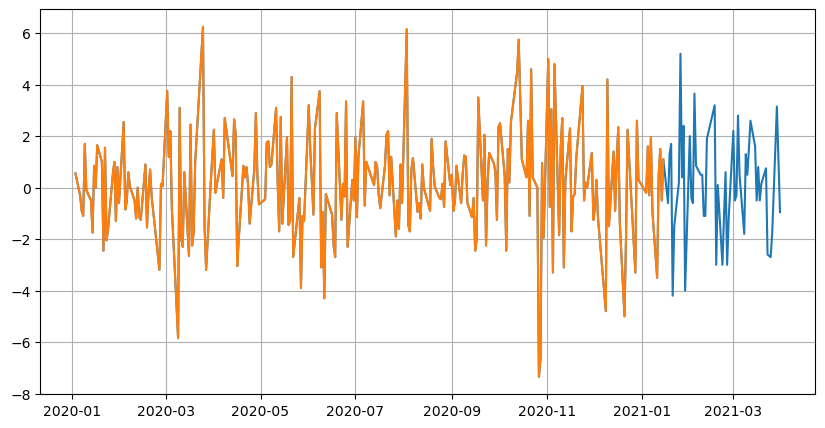

In [21]:
arima_data.loc[:len(arima_data)-len_train+1, ['Differenced_ARIMA_Price']] = list(arima_model_fit.predict()[1:])
arima_data.loc[:len(arima_data)-len_train+1, ['Differenced_Rolling_ARIMA_Price']] = list(arima_model_fit.predict()[1:])

plt.figure(figsize=(10, 5))
plt.plot(arima_data['Date'], arima_data['Differenced_Price'])
plt.plot(arima_data['Date'], arima_data['Differenced_ARIMA_Price'])
plt.grid()
plt.show()

In [22]:
arima_data

,Date,Price,Open,High,Low,Vol.,Change %,Differenced_Price,Differenced_ARIMA_Price,Differenced_Rolling_ARIMA_Price
298,2020-01-03,48.80,48.25,49.45,46.50,595.36,0.0114,0.55,0.55,0.55
297,2020-01-06,48.50,48.40,48.70,47.00,719.24,-0.0061,-0.30,-0.30,-0.30
296,2020-01-07,47.60,48.35,49.00,46.90,901.95,-0.0186,-0.90,-0.90,-0.90
295,2020-01-08,46.50,47.50,47.50,46.00,1.18,-0.0231,-1.10,-1.10,-1.10
294,2020-01-09,48.20,46.55,48.50,46.05,1.77,0.0366,1.70,1.70,1.70
...,...,...,...,...,...,...,...,...,...,...
4,2021-03-25,83.60,85.20,87.30,82.10,389.78,-0.0313,-2.70,NaN,NaN
3,2021-03-26,81.85,84.00,84.60,80.70,462.55,-0.0209,-1.75,NaN,NaN
2,2021-03-29,85.00,80.00,86.00,79.00,371.22,0.0385,3.15,NaN,NaN
1,2021-03-30,86.10,85.15,86.75,84.60,141.40,0.0129,1.10,NaN,NaN


In [23]:
arima_data.loc[len(arima_data)-len_train:, ['Differenced_ARIMA_Price']] = list(arima_model_fit.forecast(steps=len(arima_data)-len_train+1))

/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


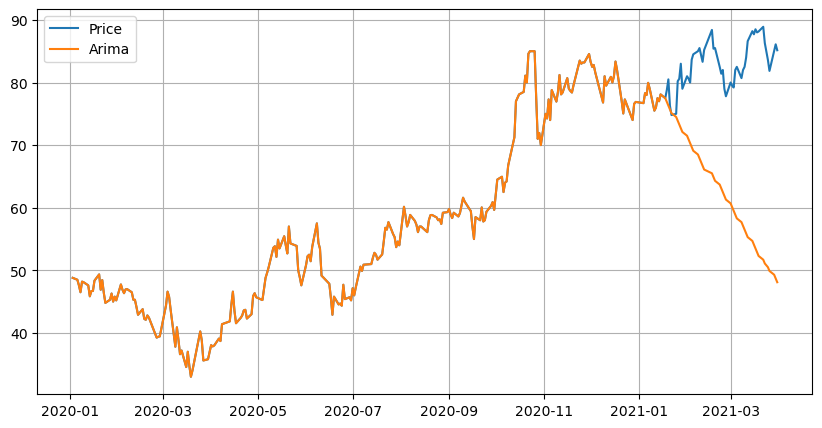

In [24]:
price = [arima_data['Price'].iloc[0]]
for i in range(1, len(arima_data)):
    price.append(price[-1]+arima_data['Differenced_ARIMA_Price'].iloc[i])

arima_data['ARIMA_Price'] = price

plt.figure(figsize=(10, 5))
plt.plot(arima_data['Date'], arima_data['Price'], label='Price')
plt.plot(arima_data['Date'], arima_data['ARIMA_Price'], label='Arima')
plt.legend()
plt.grid()
plt.show()

#### 3.2 Rolling AutoRegrssive Integrated Model Average (R-ARIMA)

One Step Prediction

In [25]:
one_step_predictions = []
for cut_point in range(len_train, len(arima_data)+1):
    arima_model = ARIMA(arima_data.loc[:len(arima_data) - cut_point, ['Differenced_Price']], order=(0, 1, 0))
    arima_model_fit = arima_model.fit()
    one_step_predictions.append(arima_model_fit.forecast().values[0])
    
arima_data.loc[len(arima_data)-len_train:, ['Differenced_Rolling_ARIMA_Price']] = one_step_predictions

/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:8

/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mj/anaconda3/envs/tf/l

/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mj/anaconda3/envs/tf/l

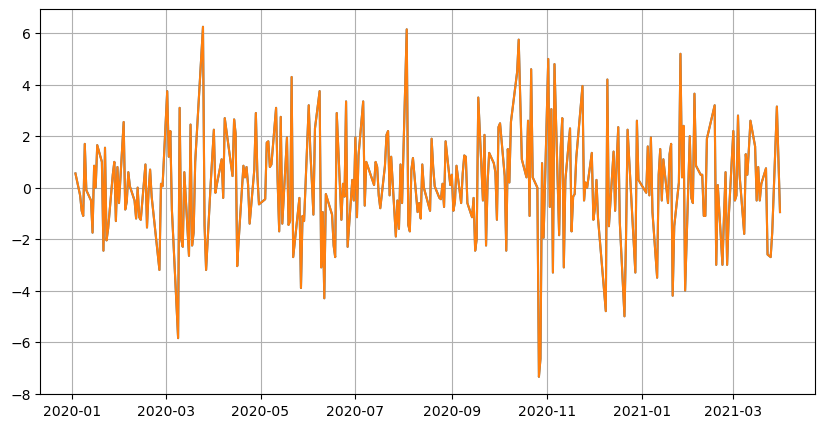

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(arima_data['Date'], arima_data['Differenced_Price'])
plt.plot(arima_data['Date'], arima_data['Differenced_Rolling_ARIMA_Price'])
plt.grid()
plt.show()

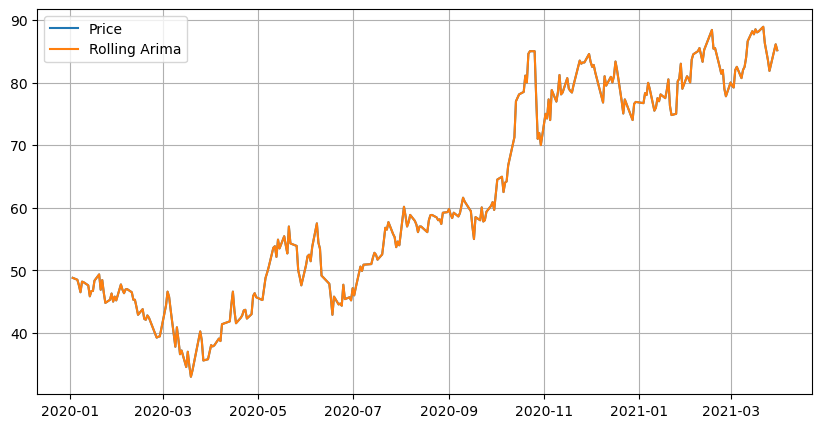

In [27]:
price = [arima_data['Price'].iloc[0]]
for i in range(1, len(arima_data)):
    price.append(price[-1]+arima_data['Differenced_Rolling_ARIMA_Price'].iloc[i])

arima_data['ARIMA_Rolling_Price'] = price

plt.figure(figsize=(10, 5))
plt.plot(arima_data['Date'], arima_data['Price'], label='Price')
plt.plot(arima_data['Date'], arima_data['ARIMA_Rolling_Price'], label='Rolling Arima')
plt.legend()
plt.grid()
plt.show()

In [28]:
arima_data

,Date,Price,Open,High,Low,Vol.,Change %,Differenced_Price,Differenced_ARIMA_Price,Differenced_Rolling_ARIMA_Price,ARIMA_Price,ARIMA_Rolling_Price
298,2020-01-03,48.80,48.25,49.45,46.50,595.36,0.0114,0.55,0.55,0.55,48.8,48.80
297,2020-01-06,48.50,48.40,48.70,47.00,719.24,-0.0061,-0.30,-0.30,-0.30,48.5,48.50
296,2020-01-07,47.60,48.35,49.00,46.90,901.95,-0.0186,-0.90,-0.90,-0.90,47.6,47.60
295,2020-01-08,46.50,47.50,47.50,46.00,1.18,-0.0231,-1.10,-1.10,-1.10,46.5,46.50
294,2020-01-09,48.20,46.55,48.50,46.05,1.77,0.0366,1.70,1.70,1.70,48.2,48.20
...,...,...,...,...,...,...,...,...,...,...,...,...
4,2021-03-25,83.60,85.20,87.30,82.10,389.78,-0.0313,-2.70,-0.60,-2.70,50.5,83.60
3,2021-03-26,81.85,84.00,84.60,80.70,462.55,-0.0209,-1.75,-0.60,-1.75,49.9,81.85
2,2021-03-29,85.00,80.00,86.00,79.00,371.22,0.0385,3.15,-0.60,3.15,49.3,85.00
1,2021-03-30,86.10,85.15,86.75,84.60,141.40,0.0129,1.10,-0.60,1.10,48.7,86.10


In [29]:
y_train = arima_data.loc[:len(df)-len_train-1, 'ARIMA_Rolling_Price'].to_numpy().reshape(-1, 1)
y_train_pred = arima_data.loc[:len(df)-len_train-1, 'Price'].to_numpy().reshape(-1, 1)
r_arima_train_rmse = np.sqrt(np.mean((y_train_pred-y_train)**2))
print('Training RMSE of Rolling ARIMA :', r_arima_train_rmse)

Training RMSE of Rolling ARIMA : 9.98751539368864e-12


In [30]:
y_pred_r_arima = arima_data.loc[len(df)-len_train-1:, 'ARIMA_Rolling_Price'].to_numpy().reshape(-1, 1)
y_test = arima_data.loc[len(df)-len_train-1:, 'Price'].to_numpy().reshape(-1, 1)
r_arima_test_rmse = np.sqrt(np.mean((y_pred_r_arima-y_test)**2))
print('Test RMSE of Rolling ARIMA :', r_arima_test_rmse)

Test RMSE of Rolling ARIMA : 1.0032863428932615e-11


## 4. Data Preprocessing

To decrease the computational cost of the data in the table, we will scale the stock values to values between 0 and 1. As a result, all of the data in large numbers is reduced, and therefore memory consumption is decreased. Also, because the data is not spread out in huge values, we can achieve greater precision by scaling down. To perform this, we will be using the MinMaxScaler class of the sci-kit-learn library.

In [31]:
from sklearn.preprocessing import MinMaxScaler

In [32]:
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[input_cols])
feature_transform = pd.DataFrame(columns=input_cols, data=feature_transform, index=df.index)
feature_transform.head()

,Open,High,Low,Vol.,Change %
299,0.304386,0.260910,0.283759,0.890554,0.329767
298,0.285088,0.246982,0.264599,0.603199,0.457520
297,0.287719,0.233055,0.273723,0.728923,0.402454
296,0.286842,0.238626,0.271898,0.914354,0.363121
295,0.271930,0.210771,0.255474,0.000173,0.348962


In [33]:
output_scaler = MinMaxScaler()
output_transform = output_scaler.fit_transform(df['Price'].to_numpy().reshape(-1, 1))
output_transform = pd.DataFrame(columns=['Price'], data=output_transform, index=df.index)
output_transform.head()

,Price
299,0.272809
298,0.282648
297,0.277281
296,0.261181
295,0.241503


Before inputting the entire dataset into the training model, we need to partition it into training and test sets. The Machine Learning LSTM model will undergo training using the data in the training set, and its accuracy and backpropagation will be tested against the test set. The training data includes data from the year 2020 (first 250 points, indicated using len_train) and the test data includes remaining dataset from 2021 Q1.

In [34]:
x_train, y_train = feature_transform.iloc[:len_train][input_cols], output_transform.iloc[:len_train]['Price']
x_test, y_test = feature_transform.iloc[len_train:][input_cols], output_transform.iloc[len_train:]['Price']

The training and test set data are transformed into a format that the LSTM model can interpret. As the LSTM needs that the data to be provided in the 3D form, the data is first transformed to NumPy arrays and then restructure them to match the LSTM format (Number of Samples, 1, Number of Features).

In [35]:
trainX =np.array(x_train)
testX =np.array(x_test)
x_train = trainX.reshape(x_train.shape[0], 1, x_train.shape[1])
x_test = testX.reshape(x_test.shape[0], 1, x_test.shape[1])

## 5 Model training

### 5.1 Long Short-Term Memory

Long-term memory (LSTM) is a deep learning artificial recurrent neural network (RNN) architecture. Unlike traditional feed-forward neural networks, LSTM has feedback connections. It can handle single data points (such as pictures) as well as full data sequences (such as speech or video).

In [36]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

In this step, we’ll build a Sequential Keras model with one LSTM layer. The LSTM layer has 32 units and is followed by one Dense Layer of one neuron.

In [37]:
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dense(1))

We compile the model using Adam Optimizer and the Mean Squared Error as the loss function. For an LSTM model, this is the most preferred combination. The model is plotted and presented below.

In [38]:
lstm.compile(loss='mean_squared_error', optimizer='adam')

Finally, the fit function is used to train the LSTM model created above on the training data for 100 epochs with a batch size of 8.

In [39]:
history=lstm.fit(x_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False)

Epoch 1/100


2024-01-03 18:16:39.763608: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


32/32 [==============================] - 1s 834us/step - loss: 0.1866
Epoch 2/100
32/32 [==============================] - 0s 785us/step - loss: 0.0932
Epoch 3/100
32/32 [==============================] - 0s 784us/step - loss: 0.0350
Epoch 4/100
32/32 [==============================] - 0s 753us/step - loss: 0.0173
Epoch 5/100
32/32 [==============================] - 0s 736us/step - loss: 0.0160
Epoch 6/100
32/32 [==============================] - 0s 699us/step - loss: 0.0138
Epoch 7/100
32/32 [==============================] - 0s 672us/step - loss: 0.0106
Epoch 8/100
32/32 [==============================] - 0s 723us/step - loss: 0.0079
Epoch 9/100
32/32 [==============================] - 0s 691us/step - loss: 0.0054
Epoch 10/100
32/32 [==============================] - 0s 713us/step - loss: 0.0034
Epoch 11/100
32/32 [==============================] - 0s 833us/step - loss: 0.0021
Epoch 12/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 13/100
32/32 [=======

32/32 [==============================] - 0s 696us/step - loss: 1.6783e-04
Epoch 97/100
32/32 [==============================] - 0s 705us/step - loss: 1.6869e-04
Epoch 98/100
32/32 [==============================] - 0s 694us/step - loss: 1.6981e-04
Epoch 99/100
32/32 [==============================] - 0s 758us/step - loss: 1.7079e-04
Epoch 100/100
32/32 [==============================] - 0s 707us/step - loss: 1.7174e-04


The trained LSTM model is used to forecast stock prices for 2021 Q1 using the `lstm.predict` function.

In [40]:
y_pred = lstm.predict(x_test)
y_pred_lstm = output_scaler.inverse_transform(y_pred)

2/2 [==============================] - 0s 1ms/step


Since stock price prediction is essentially a regression problem, the Root Mean Squared Error (RMSE) will be our current model evaluation metric.

In [41]:
raw_y_test = output_scaler.inverse_transform(np.array(y_test).reshape(-1, 1))
lstm_test_rmse = np.sqrt(np.mean((y_pred_lstm-raw_y_test)**2))
print('Test RMSE of LSTM model :', lstm_test_rmse)

Test RMSE of LSTM model : 0.8206189727782032


In [42]:
y_pred_train = lstm.predict(x_train)
y_pred_train_lstm = output_scaler.inverse_transform(y_pred_train)

raw_y_train = output_scaler.inverse_transform(np.array(y_train).reshape(-1, 1))
lstm_train_rmse = np.sqrt(np.mean((y_pred_train_lstm-raw_y_train)**2))
print('Training RMSE of LSTM model :', lstm_train_rmse)

8/8 [==============================] - 0s 600us/step
Training RMSE of LSTM model : 0.7791237467757839


RMSE gives the differences between predicted and true values since the stock price for 2021 Q1 varies between 260 to 295, RMSE error of 1.41 suggests that LSTM predictions are close to true stock prices.

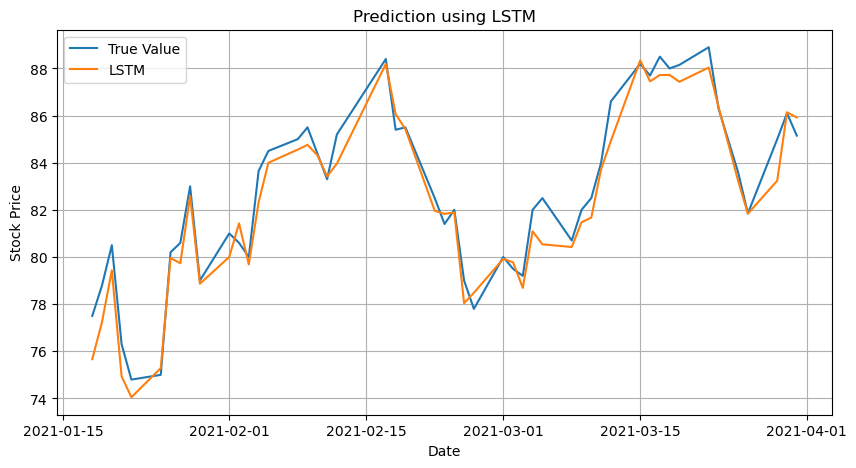

In [43]:
plt.figure(figsize=(10, 5))
plt.plot(df.iloc[len_train:]['Date'], raw_y_test, label='True Value')
plt.plot(df.iloc[len_train:]['Date'], y_pred_lstm, label='LSTM')
plt.title("Prediction using LSTM")
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()

### 5.2 Prophet

Prophet (developed bu Meta) is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

In [44]:
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


Select only the important features i.e. the date and price and rename the features: These names are NEEDED for the model fitting.

In [45]:
prophet_data = df.iloc[:len_train] # select Date and Price
# prophet_data['Price'] = output_scaler.transform(prophet_data['Price'].to_numpy().reshape(-1, 1))
# prophet_data[input_cols] = scaler.transform(prophet_data[input_cols].to_numpy())
prophet_data = prophet_data.rename(columns = {"Date": "ds", "Price": "y"}) #renaming the columns of the dataset
prophet_data.head(5)

,ds,y,Open,High,Low,Vol.,Change %
299,2020-01-02,48.25,49.35,50.20,47.55,878.50,-0.0292
298,2020-01-03,48.80,48.25,49.45,46.50,595.36,0.0114
297,2020-01-06,48.50,48.40,48.70,47.00,719.24,-0.0061
296,2020-01-07,47.60,48.35,49.00,46.90,901.95,-0.0186
295,2020-01-08,46.50,47.50,47.50,46.00,1.18,-0.0231


In [46]:
prophet_model = Prophet()

In [47]:
for feature in input_cols:
    prophet_model.add_regressor(feature)

In [48]:
prophet_model.fit(prophet_data)

18:16:43 - cmdstanpy - INFO - Chain [1] start processing
18:16:43 - cmdstanpy - INFO - Chain [1] done processing


In [49]:
forecast = prophet_model.predict(df[['Date']+input_cols].rename(columns={"Date": "ds"}))
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
295,2021-03-25,84.372496,83.471968,85.354986
296,2021-03-26,82.335187,81.376418,83.358282
297,2021-03-29,83.760950,82.798565,84.782383
298,2021-03-30,85.698517,84.730131,86.615377
299,2021-03-31,86.328905,85.368992,87.210451


/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/prophet/plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


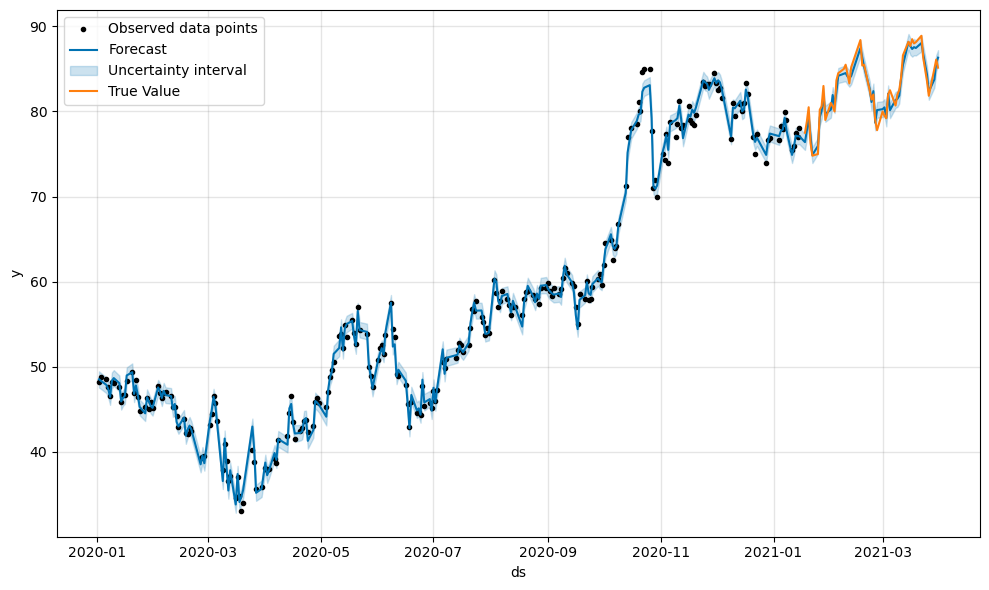

In [50]:
fig1 = prophet_model.plot(forecast)
plt.plot(df.iloc[len_train:]['Date'], raw_y_test, label='True Value', color='C1')
plt.legend()
plt.show()

In [51]:
y_train = df.loc[:len(df)-len_train, 'Price'].to_numpy().reshape(-1, 1)
y_pred_train = forecast.loc[:len_train-1, 'yhat'].to_numpy().reshape(-1, 1)
prophet_train_rmse = np.sqrt(np.mean((y_pred_train-y_train)**2))
print('Training RMSE of Prophet model:', prophet_train_rmse)

Training RMSE of Prophet model: 0.7347509618523792


In [52]:
y_test = df.loc[len(df)-len_train-1:, 'Price'].to_numpy().reshape(-1, 1)
y_pred_prophet = forecast.loc[len_train:, 'yhat'].to_numpy().reshape(-1, 1)
prophet_test_rmse = np.sqrt(np.mean((y_pred_prophet-y_test)**2))
print('Test RMSE of Prophet model :', prophet_test_rmse)

Test RMSE of Prophet model : 0.8901422144574895


## 6. Optimal Strategy

To recommend decisions (BUY, SELL, HOLD) using the model prediction. An optimal strategy adopted here is to

- BUY: if the stock price decreases and going up
- SELL: if the stock price increases and going down
- HOLD: if the stock price increased and still increasing

In [53]:
def recommendation_strategy(prices):
    prediction_recommendation = []
    stock_indicator = False
    
    if prices[0] < prices[1]:
        prediction_recommendation.append('BUY')
        buy_price = prices[0]
        stock_indicator = True
    else:
        prediction_recommendation.append('HOLD')
        
    for i in range(1, len(prices)-1):
        if prices[i] < prices[i-1] and prices[i] < prices[i+1]:
            prediction_recommendation.append('BUY')
            buy_price = prices[i]
            stock_indicator = True
        elif prices[i] > prices[i-1] and prices[i] > prices[i+1] and stock_indicator:
            prediction_recommendation.append('SELL')
            stock_indicator = False
        else:
            prediction_recommendation.append('HOLD')
            
    prediction_recommendation.append('HOLD')
        
    return prediction_recommendation

In [54]:
def compute_profit(prediction_recommendation, true):
    profit = 0
    old_counter = None
    old_status = prediction_recommendation[0]
    if old_status == 'BUY':
        old_counter = 0
    for i in range(1, len(prediction_recommendation)):
        if prediction_recommendation[i] == 'SELL' and old_status == 'BUY':
            profit += true[i] - true[old_counter]
            old_counter, old_status = None, None
        if prediction_recommendation[i] == 'BUY':
            old_counter, old_status = i, 'BUY'
    return profit

In [55]:
dream_recommendation = recommendation_strategy(np.array(y_test))
dream_profit = compute_profit(dream_recommendation, np.array(y_test))
print('Dream profit using true stock prices: ', dream_profit)

Dream profit using true stock prices:  [43.45]


In [56]:
r_arima_recommendation = recommendation_strategy(np.array(y_pred_r_arima)[:, 0])
r_arima_expected_profit = compute_profit(r_arima_recommendation, np.array(y_test))
print('Expected profit using Rolling ARIMA model predictions: ', r_arima_expected_profit)

Expected profit using Rolling ARIMA model predictions:  [43.45]


In [57]:
lstm_recommendation = recommendation_strategy(np.array(y_pred_lstm)[:, 0])
lstm_expected_profit = compute_profit(lstm_recommendation, np.array(y_test))
print('Expected profit using LSTM model predictions: ', lstm_expected_profit)

Expected profit using LSTM model predictions:  [40.2]


In [58]:
prophet_recommendation = recommendation_strategy(np.array(y_pred_prophet)[:, 0])
prophet_expected_profit = compute_profit(prophet_recommendation, np.array(y_test))
print('Expected profit using LSTM model predictions: ', prophet_expected_profit)

Expected profit using LSTM model predictions:  [33.25]


In [59]:
ans = df.iloc[len_train:].copy()
ans['R-ARIMA Recommendation'] = r_arima_recommendation
ans['LSTM Recommendation'] = lstm_recommendation
ans['Prophet Recommendation'] = prophet_recommendation
ans

,Date,Price,Open,High,Low,Vol.,Change %,R-ARIMA Recommendation,LSTM Recommendation,Prophet Recommendation
49,2021-01-18,77.50,76.10,77.50,75.10,172.50,-0.0077,BUY,BUY,BUY
48,2021-01-19,78.80,76.10,79.00,76.10,569.39,0.0168,HOLD,HOLD,HOLD
47,2021-01-20,80.50,78.70,80.50,77.25,392.64,0.0216,SELL,SELL,SELL
46,2021-01-21,76.30,78.10,80.10,75.50,651.66,-0.0522,HOLD,HOLD,HOLD
45,2021-01-22,74.80,76.00,76.50,73.80,504.59,-0.0197,BUY,BUY,BUY
44,2021-01-25,75.00,75.70,77.50,73.80,498.45,0.0027,HOLD,HOLD,HOLD
43,2021-01-26,80.20,76.00,80.25,76.00,665.23,0.0693,HOLD,SELL,HOLD
42,2021-01-27,80.60,80.10,82.20,77.80,631.75,0.0050,HOLD,BUY,HOLD
41,2021-01-28,83.00,81.90,83.00,79.45,376.95,0.0298,SELL,SELL,SELL
40,2021-01-29,79.00,83.00,83.50,77.50,141.12,-0.0482,BUY,BUY,BUY


## 7. Model Artifacts

In [60]:
results = {'profit': [r_arima_expected_profit, lstm_expected_profit, prophet_expected_profit],
           'train_rmse': [r_arima_train_rmse, lstm_train_rmse, prophet_train_rmse],
           'test_rmse': [r_arima_test_rmse, lstm_test_rmse, prophet_test_rmse],
           'Dream Profit': dream_profit}

In [61]:
import pathlib
import pickle

file = pathlib.Path("results.pkl")
if file.exists ():
    # Open pickle file
    with open('results.pkl', 'rb') as fp:
        saved_results = pickle.load(fp)
    saved_results['Argentina-PAMP'] = results
    
    # Upadte pickle file
    with open('results.pkl', 'wb') as fp:
        pickle.dump(saved_results, fp)
else:
    # Create a pickle file to store results
    with open('results.pkl', 'wb') as fp:
        pickle.dump({'Argentina-PAMP': results}, fp)

## 8. Bollinger Bands

Calculation of Bollinger bands.

$$ U = MA(TP, n) + m \times \sigma(TP, n) $$
$$ L = MA(TP, n) - m \times \sigma(TP, n) $$

where,

U: Bollinger upper limit

L: Bollinger lower limit

MA(TP, n): Average over last n periods of TP values

TP: Typical price,  (low + high + close)/3

n: Smoothing period (typical 20)

m: Number of standard deviation (typically 2)

$\sigma(TP, n)$: Standard deviation over last n periods of TP values

In [62]:
smoothing_period = 20
m_std = 2
y_val = np.array((df.Price + df.High + df.Low)/3)[250-smoothing_period:]

In [63]:
moving_avg, bol_upper, bol_lower = [], [], []
for i in range(len(y_val)-smoothing_period):
    tmp = y_val[i:i+smoothing_period]
    moving_avg.append(np.mean(tmp))
    sigma = np.std(tmp)
    bol_upper.append(moving_avg[-1]+m_std*sigma)
    bol_lower.append(moving_avg[-1]-m_std*sigma)

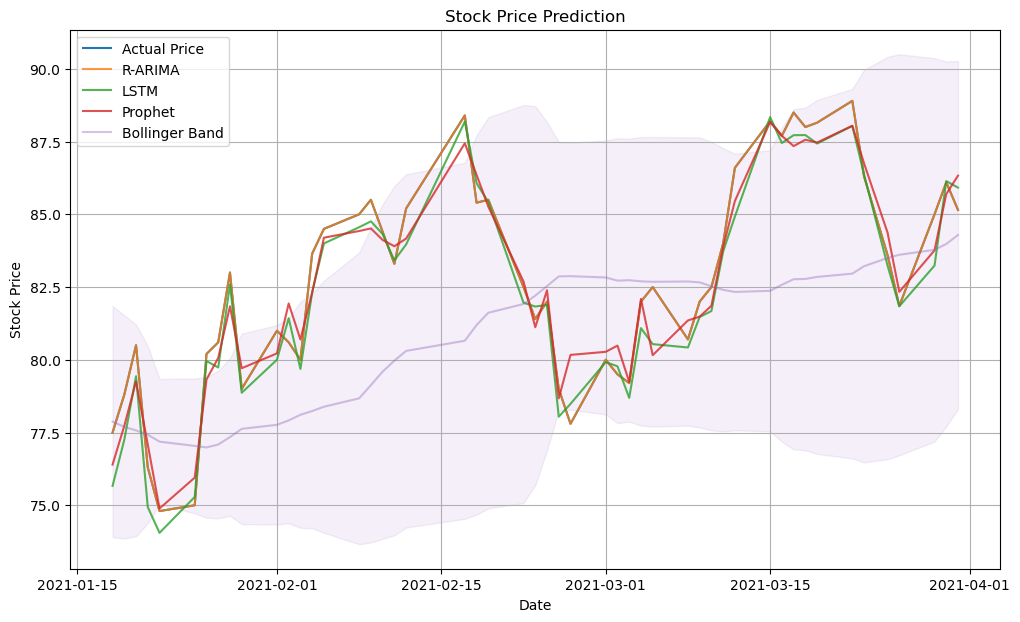

In [64]:
plt.figure(figsize=(12, 7))
plt.plot(df.iloc[len_train:]['Date'], df.iloc[len_train:]['Price'], label='Actual Price')
plt.plot(df.iloc[len_train:]['Date'], y_pred_r_arima, label='R-ARIMA', alpha=.8)
plt.plot(df.iloc[len_train:]['Date'], y_pred_lstm, label='LSTM', alpha=.8)
plt.plot(df.iloc[len_train:]['Date'], y_pred_prophet, label='Prophet', alpha=.8)
plt.plot(df.iloc[len_train:]['Date'], moving_avg, label='Bollinger Band', alpha=.4)
plt.fill_between(df.iloc[len_train:]['Date'], bol_lower, bol_upper, color='C4', alpha=.1)
plt.title("Stock Price Prediction")
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()

Prices can "walk the band" during a strong down- or uptrend. This means that there are repeated instances of a price touching or breaking through the lower or upper band. That's why you may not want to take action when the price touches either band—you might, instead, prefer to wait and look for chart patterns like the "double bottom," a "classic M top," or a "three pushes to high" formation.

- Double bottom: This occurs when there is a fall in price, followed by a rise, followed by another fall that is close to the previous low, and finally another rise.

- Classic M top: This shape is formed by a push to a high, followed by sell-off reaction, and then a test of the previous high. The second high can be higher or lower than the first high.

- Three pushes to high: A top often develops as a leading edge of a larger, longer topping formation. The way it forms is typically like this: The first push creates a new high outside the upper band; the second push makes a new high and touches the upper band; the third push makes a new high, but within the upper band.

Based on these formation and observation, 

- A double bottom can be observed between 2021-02-01 and 2021-02-15, which suggests an upward trend and recommend buying (`BUY`) stock. 

- A classic M top can be observed between 2021-03-01 and 2021-03-15, which recommend selling (`SELL`) stock.